In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [7]:
temp = pd.read_csv('resources/temp_by_date.csv')
temp.columns = temp.columns.str.strip()
temp.head()

,STN---,WBAN,YEARMODA,TEMP,,DEWP,.1,SLP,.2,STP,...,WDSP,.5,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,Unnamed: 22
0,997338,99999,20050322,35.0,12,9999.9,0,9999.9,0,9999.9,...,16.9,12,23.9,999.9,35.4*,34.3*,0.00I,999.9,0,NaN
1,997338,99999,20050323,35.1,24,9999.9,0,9999.9,0,9999.9,...,19.0,24,23.9,999.9,37.2*,32.5*,0.00I,999.9,0,NaN
2,997338,99999,20050324,34.0,24,9999.9,0,9999.9,0,9999.9,...,7.9,24,16.9,999.9,36.3*,31.3*,0.00I,999.9,0,NaN
3,997338,99999,20050325,34.6,24,9999.9,0,9999.9,0,9999.9,...,11.1,24,18.1,999.9,36.7*,32.0*,0.00I,999.9,0,NaN
4,997338,99999,20050326,34.2,21,9999.9,0,9999.9,0,9999.9,...,9.0,21,15.9,999.9,35.1*,33.3*,0.00I,999.9,0,NaN


In [8]:
temp = temp[['YEARMODA', 'TEMP', 'PRCP']]
temp['YEAR'] = temp['YEARMODA'].astype(str).map(lambda x: x[:4])
temp['MONTH'] = temp['YEARMODA'].astype(str).map(lambda x: x[4:6])
temp['DAY'] = temp['YEARMODA'].astype(str).map(lambda x: x[6:])
temp = temp.drop('YEARMODA', axis=1)
temp = temp.set_index(['YEAR', 'MONTH', 'DAY'])

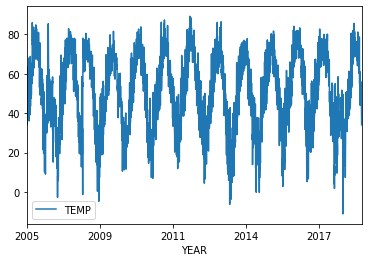

In [21]:
temp.reset_index().set_index('YEAR')[['TEMP']].plot()

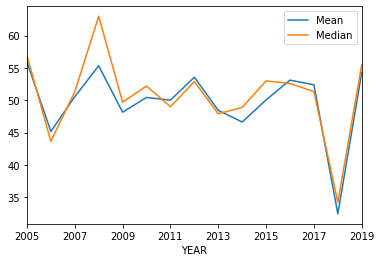

In [22]:
mean_temp_by_year = temp[['TEMP']].groupby('YEAR').mean()
median_temp_by_year = temp[['TEMP']].groupby('YEAR').median()

ax = mean_temp_by_year.plot()
median_temp_by_year.plot(ax=ax)
ax.legend(['Mean', 'Median'])

In [3]:
import pyarrow.parquet as pq
path = 'resources/extended_dataset.parquet'
df = pd.read_parquet(path)
df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,"[3, 5, 25, 50, 53, 53, 56, 58]",8,2,1,5


Text(0.5, 1.0, 'Number of inspections by year')

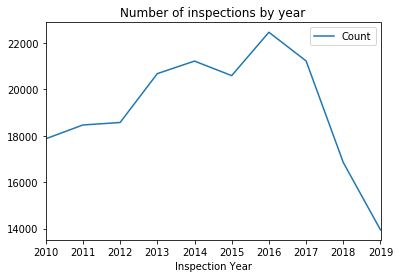

In [24]:
nb_inspections_by_year = df[['Inspection Date', 'Inspection ID']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year).astype(str)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'Inspection ID' : 'Count'})
nb_inspections_by_year.plot()
plt.title("Number of inspections by year")

In [25]:
df_joined_inspections = nb_inspections_by_year.rename(index={'Inspection Year' : 'YEAR'}).join(mean_temp_by_year)
df_joined_inspections

,Count,TEMP
Inspection Year,,
2010,17866,50.431549
2011,18461,50.015746
2012,18568,53.566942
2013,20672,48.443802
2014,21213,46.631129
2015,20587,50.051695
2016,22455,53.117080
2017,21219,52.385359
2018,16844,32.410435


In [26]:
df_joined_inspections.corr()

,Count,TEMP
Count,1.000000,0.149667
TEMP,0.149667,1.000000


Text(0.5, 1.0, 'Number of failed inspections by year')

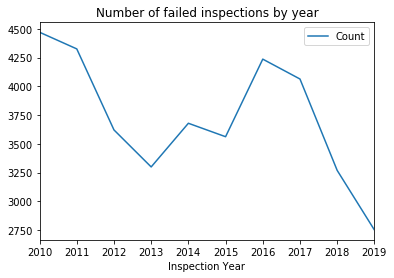

In [27]:
nb_fails_by_year= df[df['Results'] == 'Fail'].copy()
nb_fails_by_year = nb_fails_by_year[['Inspection Date', 'Inspection ID']]
nb_fails_by_year['Inspection Date'] = nb_fails_by_year['Inspection Date'].apply(lambda x: x.year).astype(str)
nb_fails_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_fails_by_year = nb_fails_by_year.groupby('Inspection Year').count().rename(columns={'Inspection ID' : 'Count'})
nb_fails_by_year.plot()
plt.title("Number of failed inspections by year")

In [28]:
df_joined_fails = nb_fails_by_year.rename(index={'Inspection Year' : 'YEAR'}).join(mean_temp_by_year)
df_joined_fails

,Count,TEMP
Inspection Year,,
2010,4471,50.431549
2011,4326,50.015746
2012,3621,53.566942
2013,3299,48.443802
2014,3679,46.631129
2015,3562,50.051695
2016,4237,53.117080
2017,4064,52.385359
2018,3269,32.410435


In [29]:
df_joined_fails.corr()

,Count,TEMP
Count,1.00000,0.22617
TEMP,0.22617,1.00000


Text(0.5, 1.0, 'Number of violations by year')

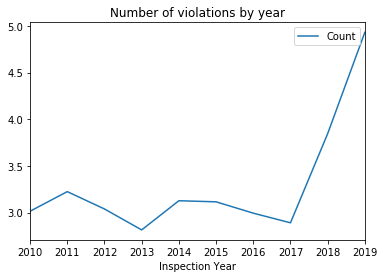

In [30]:
nb_violations_by_year = df[['Inspection Date', 'Nb Violations']].copy()
nb_violations_by_year['Inspection Date'] = nb_violations_by_year['Inspection Date'].apply(lambda x: x.year).astype(str)
nb_violations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_violations_by_year = nb_violations_by_year.groupby('Inspection Year').mean().rename(columns={'Nb Violations' : 'Count'})
nb_violations_by_year.plot()
plt.title("Number of violations by year")

In [31]:
df_joined_violations = nb_violations_by_year.rename(index={'Inspection Year' : 'YEAR'}).join(mean_temp_by_year)
df_joined_violations

,Count,TEMP
Inspection Year,,
2010,3.014105,50.431549
2011,3.223932,50.015746
2012,3.038130,53.566942
2013,2.813758,48.443802
2014,3.126432,46.631129
2015,3.114733,50.051695
2016,2.993275,53.117080
2017,2.889957,52.385359
2018,3.845346,32.410435


In [32]:
df_joined_violations.corr()

,Count,TEMP
Count,1.000000,-0.116529
TEMP,-0.116529,1.000000


Nothing interesting...

In [4]:
violations_per_month = pd.read_parquet('resources/violations_per_month.parquet')

In [11]:
mean_temp_by_month = temp[['TEMP']].groupby('MONTH').mean().set_index(np.arange(1,13))

In [13]:
df_joined_violations_month = violations_per_month.join(mean_temp_by_month['TEMP'])
df_joined_violations_month.head(12)

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,TEMP
Inspection Month,,,,,
1,219.694581,18.551724,21.103448,180.039409,25.793566
2,223.502703,20.772973,21.924324,180.805405,27.666964
3,224.861751,20.248848,22.225806,182.387097,37.381003
4,217.129032,19.986175,22.225806,174.917051,45.693846
5,236.607477,22.434579,23.570093,190.602804,56.095291
6,229.536697,21.435780,23.435780,184.665138,66.929973
7,198.905213,24.592417,20.388626,153.924171,72.819903
8,227.400000,27.955556,24.253333,175.191111,72.662944
9,230.995098,25.225490,25.000000,180.769608,66.984492


In [15]:
df_joined_violations_month.corr()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,TEMP
Nb Violations,1.000000,0.697024,0.938207,0.982377,0.327993
Nb Violations of high severity,0.697024,1.000000,0.804990,0.553489,0.778179
Nb Violations of medium severity,0.938207,0.804990,1.000000,0.872734,0.547345
Nb Violations of low severity,0.982377,0.553489,0.872734,1.000000,0.171160
TEMP,0.327993,0.778179,0.547345,0.171160,1.000000


By looking at the Violations of high severity, we see that some of them are related with the temperature. Building on the fact that the temperature is warmer during the summer, the correlation between the number of violations of high severity and the temperature is higher during the summer.